# EDF format checks

## There are 3 potential issues related to the conversion of raw signals to EDF:

1. Signal clipping:    signal cut once it exceeds an amplitude threshold
                        (the min-max range set before EDF conversion was 
                        too narrow)
2. Bit depth:          signal shows a stair-like progression (the min-max
                        range set before EDF conversion was too wide)
3. Inverted polarity:  signal multiplied by -1 

The present script is semi-automated: for each subject and channel,
figures are plotted to make a visual inspection. Problematic files are
stored in a table.

## How to run this notebook

Run each block one by one and be attentive to the prompted windows when user
imput is required and read the notes in the comments for specific instructions.

In [1]:
# Import libraries
import os
import ipywidgets as widgets
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Defined the show_channels_histogram function
# This function iterates a list of file/channels and plots their distribution
# or a function of it (estimator(channel_data))
plt.rcParams["figure.figsize"] = (12,8)

def show_channels_histograms(file_channels, subfolder, estimator=lambda x: x):
    if len(file_channels) > 0:
        total_channels = len(file_channels)
        total_files = len(np.unique(file_channels["File"]))
        print(f'>>> {total_channels} chanels (from {total_files} EDF files) might have a signal clipping issue.')

        print(file_channels)
        reply = input('Do you want to visually inspect these channels? Type ''y'' (YES) or ''n'' (NO)')
        if reply == 'y':
            print(f'>>> Ok, plotting histograms for these {total_channels} channels...')
            
            for filename, channels in file_channels.groupby('File'):
                data = mne.io.read_raw_edf(
                    os.path.join(subfolder,filename),
                    preload=True,
                    verbose=True
                )

                for i, row in channels.iterrows():
                    channel = row['Channel']
                    unit = row['Unit']
                    
                    scaler = 1e+6 if unit == 'µV' else 1e+3
                    X = data.get_data([channel])[0]
                    X = estimator(X * scaler)

                    # Plot figure
                    sns.histplot(
                        X,
                        stat='percent',
                        bins=500,
                        kde=True
                    )

                    max_x = X.max() + abs(X.max())*0.05
                    min_x = X.min() - abs(X.min())*0.05
                    plt.xlim(min_x,max_x)
                    plt.title(f'{filename} ({channel}) Amplitude distribution')
                    plt.ylabel('Data points distribution (%)')
                    plt.xlabel(f'Amplitude ({unit})')
                    plt.show()
    else:
        print('>>> No signal clipping issue was detected.')

In [3]:
# Path to EDF files: select folder containing the EDF files
subfolder = input('>>> input the folder path containing the EDF files')

# Path to EDF files: select folder containing the EDF files
filelist = [
    f for f in os.listdir(subfolder)
    if os.path.isfile(os.path.join(subfolder, f))
    and f[-4:] == '.edf'
]

print(f'>>> {len(filelist)} EDF files found')

>>> 3 EDF files found


In [4]:
# Select the EDF file to check.
# NOTE: Selection is automatically set each time you select one or more items from
# the shown menu. Once you select the files you want to use, continue by just 
# running the following blocks. At any time you can comeback to select new items
# and re run the following blocks for that new selection.
w = widgets.SelectMultiple(
    options=filelist,
    description='Select the EDF file to check',
    disabled=False
)

w

SelectMultiple(description='Select the EDF file to check', options=('02ZB_EEG_clipped.edf', '01HC_EEG_clean.ed…

In [5]:
# Loop across selected files
dfs = []
for subID in w.value:
    
    # Import the data
    print(f'>>> >>> Importing data from Subject {subID[:-4]}...')
    file_path = os.path.join(subfolder, subID)
    data = mne.io.read_raw_edf(file_path, preload=True, verbose=True)
    all_ch_names = data.info['ch_names']
        
    ## Check for signal clipping and bit depth issue
       
    subject_summary_rows = []
    for ch_name in tqdm(all_ch_names):
        
        unit = data._orig_units[ch_name]

        scaler = 1e+6 if unit == 'µV' else 1e+3
        Data = data.get_data([ch_name])[0] * scaler
        
        delta_ampl = np.abs(np.diff(Data))
        delta_ampl = delta_ampl[delta_ampl != 0]

        subject_summary_rows.append([
            subID,
            ch_name,
            data._orig_units[ch_name],
            min(Data),
            max(Data),
            min(delta_ampl)
        ])

    dfs.append(pd.DataFrame(
        subject_summary_rows,
        columns=['File', 'Channel', 'Unit', 'Min', 'Max', 'BinGap']
    ))

summary_table = pd.concat(dfs)

>>> >>> Importing data from Subject 02ZB_EEG_clipped...
Extracting EDF parameters from /home/laouen.belloli/Documents/git/eeg-club/data/Demo/EDF/02ZB_EEG_clipped.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1965567  =      0.000 ...  7677.996 secs...


  0%|          | 0/6 [00:00<?, ?it/s]

>>> >>> Importing data from Subject 01HC_EEG_clean...
Extracting EDF parameters from /home/laouen.belloli/Documents/git/eeg-club/data/Demo/EDF/01HC_EEG_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1599487  =      0.000 ...  6247.996 secs...


  0%|          | 0/6 [00:00<?, ?it/s]

>>> >>> Importing data from Subject RL01NA01_bindpeth...
Extracting EDF parameters from /home/laouen.belloli/Documents/git/eeg-club/data/Demo/EDF/RL01NA01_bindpeth.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4926399  =      0.000 ...  2405.468 secs...


  0%|          | 0/17 [00:00<?, ?it/s]

>>> 15 chanels (from 2 EDF files) might have a signal clipping issue.
                     File      Channel Unit      Min      Max    BinGap
0    02ZB_EEG_clipped.edf       Fp1-A2   µV   -100.0    100.0  0.003052
1    02ZB_EEG_clipped.edf        C3-A2   µV   -100.0    100.0  0.003052
2    02ZB_EEG_clipped.edf        O1-A2   µV   -100.0    100.0  0.003052
3    02ZB_EEG_clipped.edf        EOG G   mV     -0.1      0.1  0.000003
4    02ZB_EEG_clipped.edf        EOG D   mV     -0.1      0.1  0.000003
5    02ZB_EEG_clipped.edf  EMG 1-EMG 2   mV     -0.1      0.1  0.000003
0   RL01NA01_bindpeth.edf          Fp1   µV -57841.1 -39950.7  0.272990
1   RL01NA01_bindpeth.edf          Fp2   µV -40770.3 -33825.5  0.105971
2   RL01NA01_bindpeth.edf           C3   µV -27450.0 -11223.7  0.247597
3   RL01NA01_bindpeth.edf           Cz   µV -39218.6 -37459.7  0.026839
4   RL01NA01_bindpeth.edf           C4   µV -77379.9 -65106.3  0.187283
5   RL01NA01_bindpeth.edf           P3   µV -70033.7 -53906.4  0.2

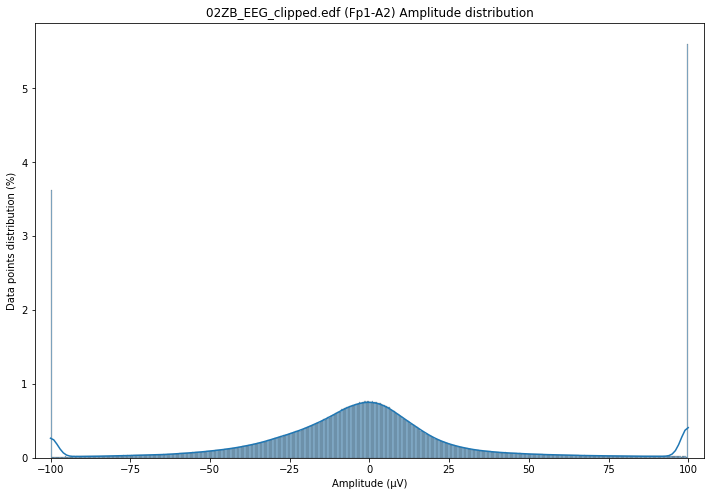

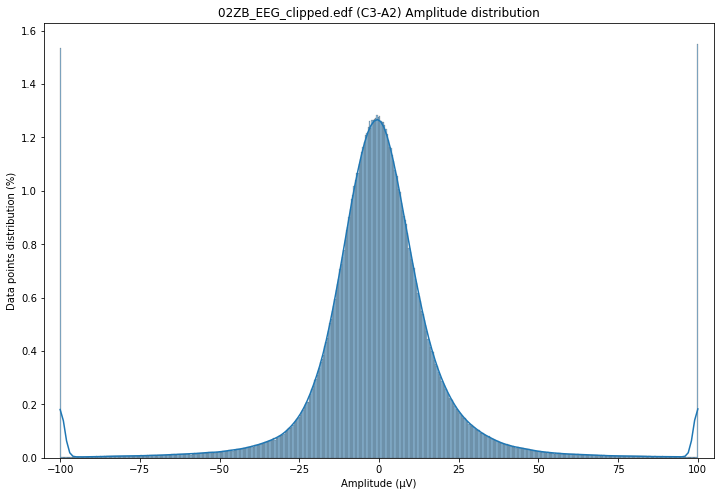

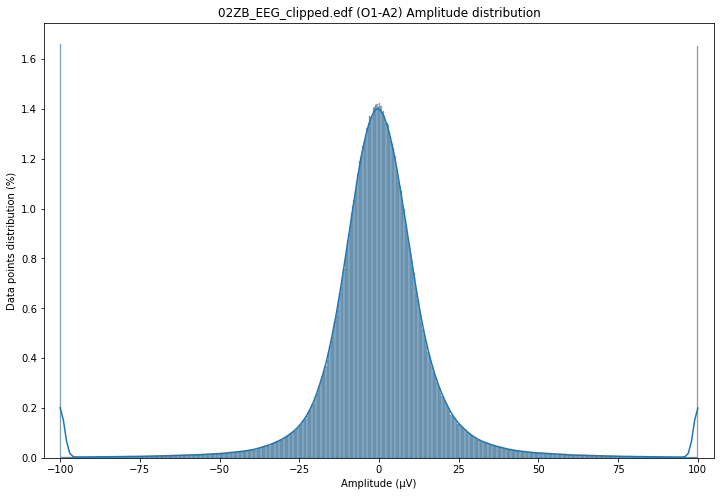

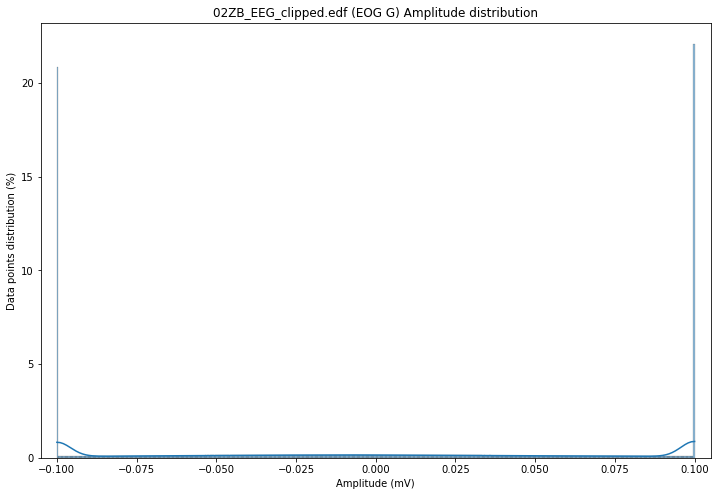

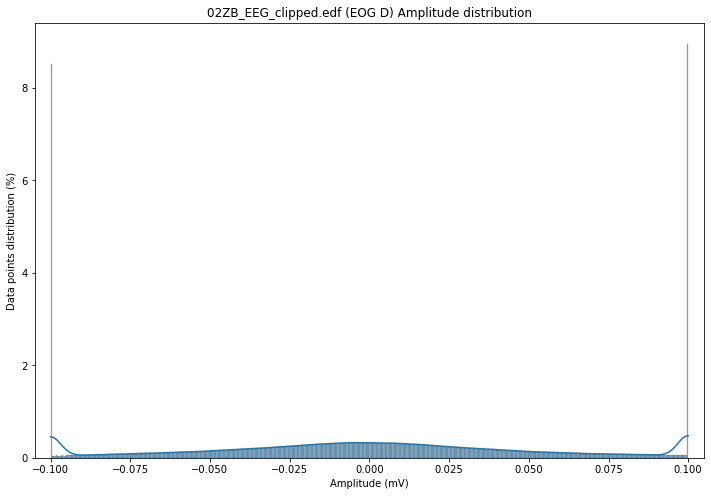

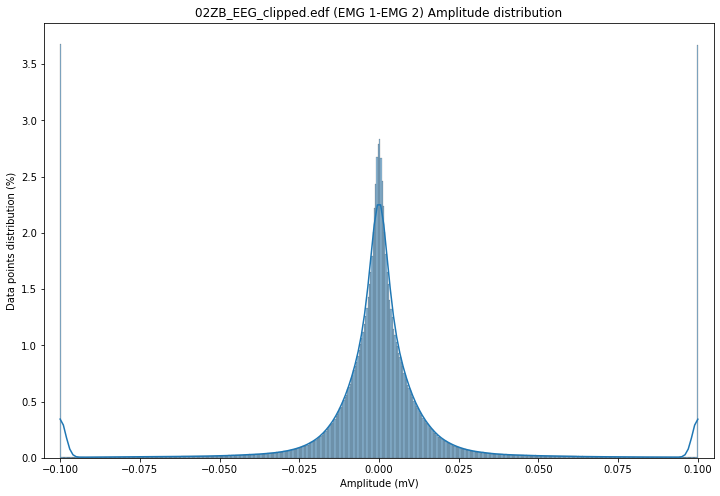

Extracting EDF parameters from /home/laouen.belloli/Documents/git/eeg-club/data/Demo/EDF/RL01NA01_bindpeth.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4926399  =      0.000 ...  2405.468 secs...


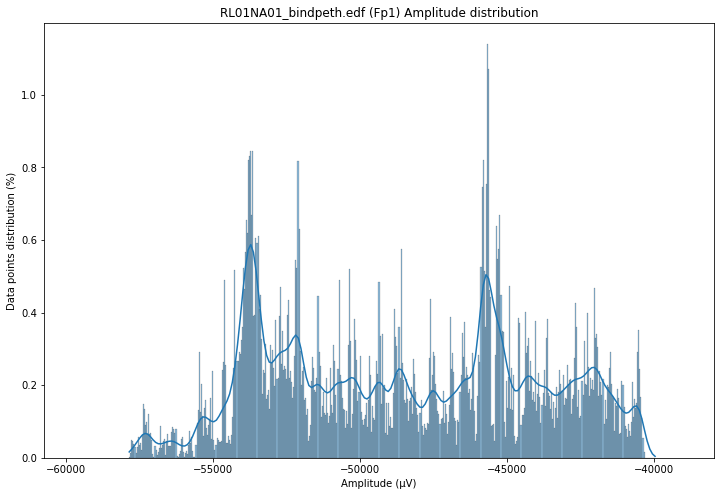

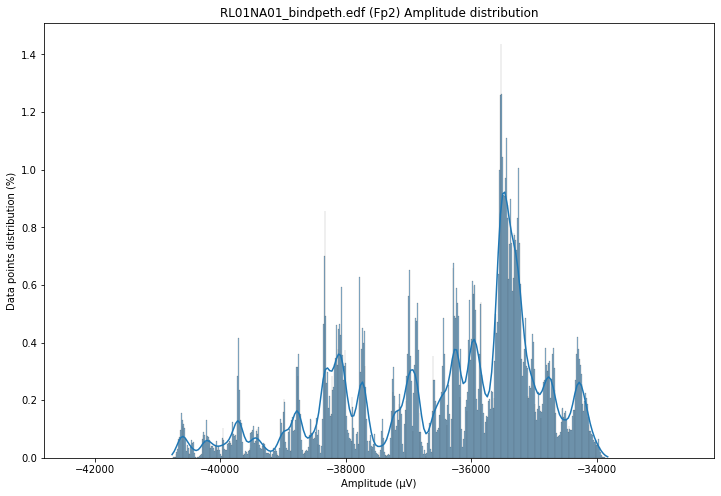

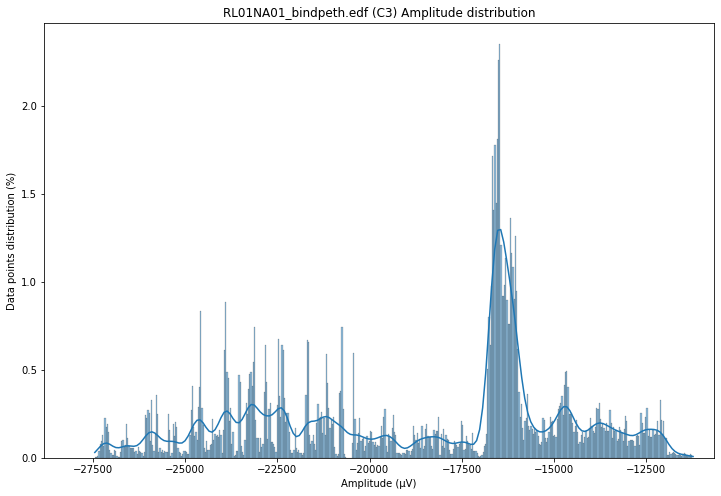

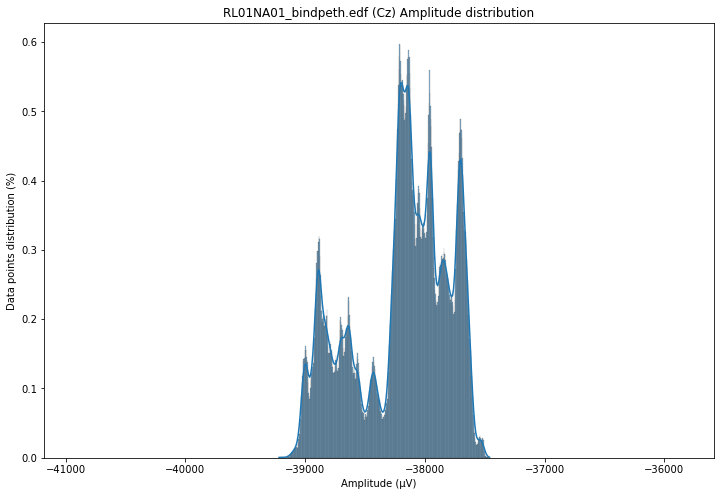

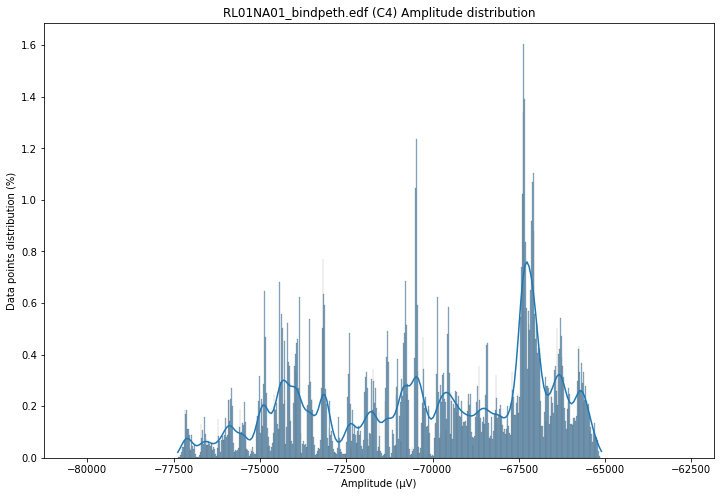

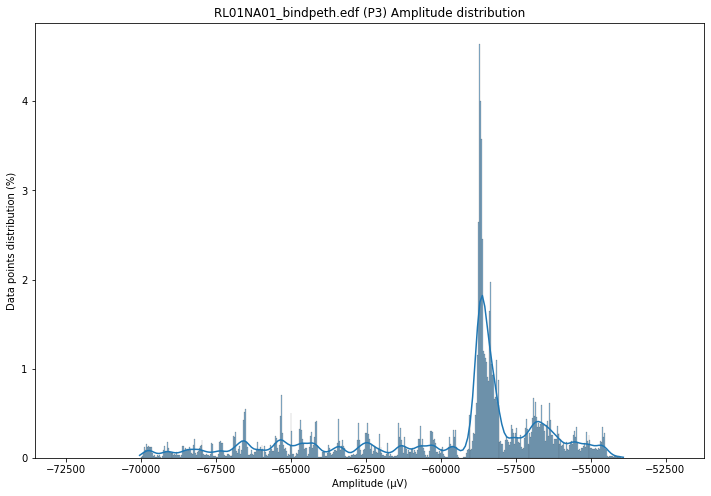

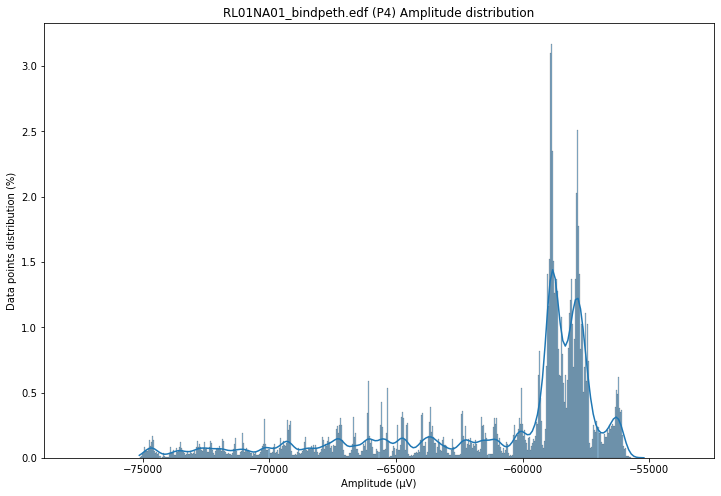

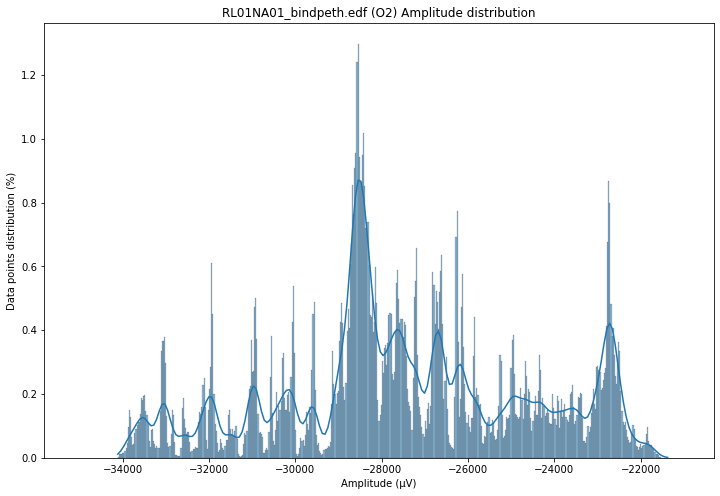

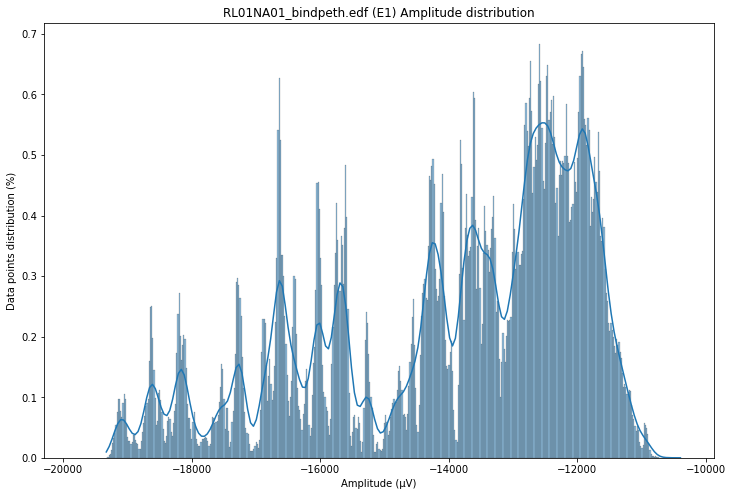

In [9]:
## Store problematic files and inspect them 
uVchan = summary_table['Unit'] == 'µV'
outOfuVRange = (summary_table['Min'] > -500) | (summary_table['Max'] < 500)
cliping_uVchan = uVchan & outOfuVRange

mVchan = summary_table['Unit'] == 'mV'
outOfmVRange = (summary_table['Min'] > -0.5) | (summary_table['Max'] < 0.5)
cliping_mVchan = mVchan & outOfmVRange

signal_clipping_files = summary_table[cliping_uVchan | cliping_mVchan]
show_channels_histograms(signal_clipping_files, subfolder)

>>> 11 chanels (from 1 EDF files) might have a signal clipping issue.
                     File Channel Unit         Min          Max     BinGap
0   RL01NA01_bindpeth.edf     Fp1   µV   -57841.10   -39950.700   0.272990
1   RL01NA01_bindpeth.edf     Fp2   µV   -40770.30   -33825.500   0.105971
2   RL01NA01_bindpeth.edf      C3   µV   -27450.00   -11223.700   0.247597
4   RL01NA01_bindpeth.edf      C4   µV   -77379.90   -65106.300   0.187283
5   RL01NA01_bindpeth.edf      P3   µV   -70033.70   -53906.400   0.246087
6   RL01NA01_bindpeth.edf      Pz   µV -1037231.00  1170406.000  33.686381
7   RL01NA01_bindpeth.edf      P4   µV   -75142.40   -55210.000   0.304149
8   RL01NA01_bindpeth.edf      O1   µV   -13034.00     2468.311   0.236550
9   RL01NA01_bindpeth.edf      O2   µV   -34117.40   -21374.500   0.194444
10  RL01NA01_bindpeth.edf      E1   µV   -19328.40   -10391.300   0.136371
11  RL01NA01_bindpeth.edf      E2   µV    -7222.68     3645.884   0.165844
>>> Ok, plotting histograms fo

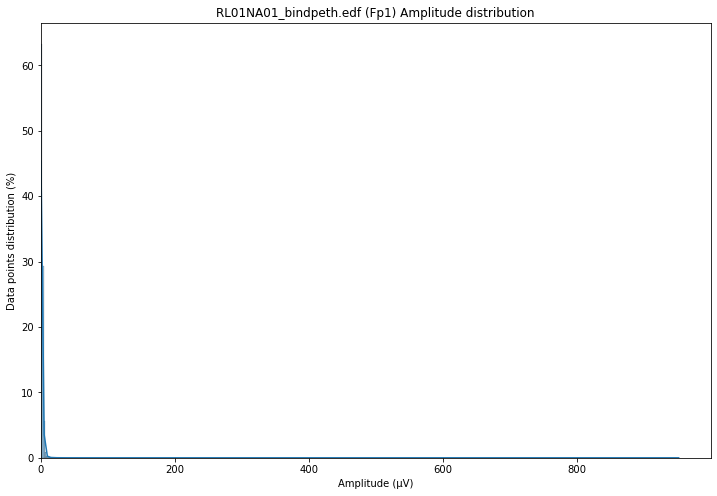

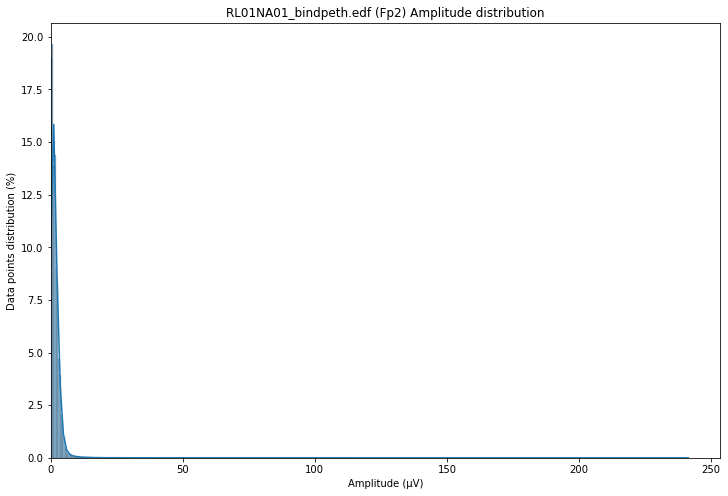

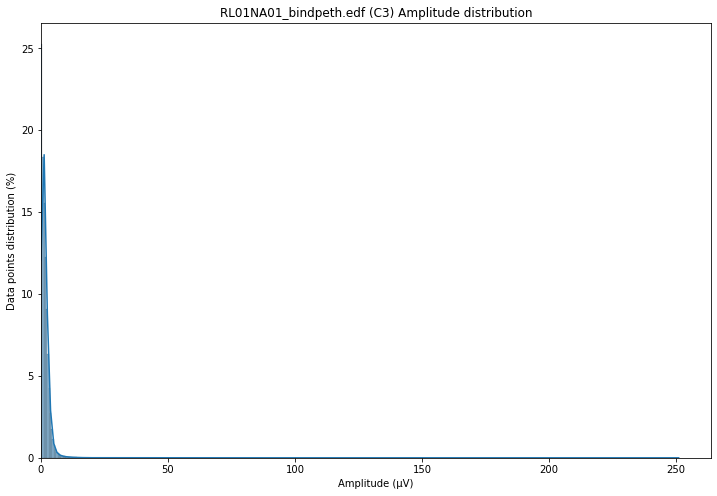

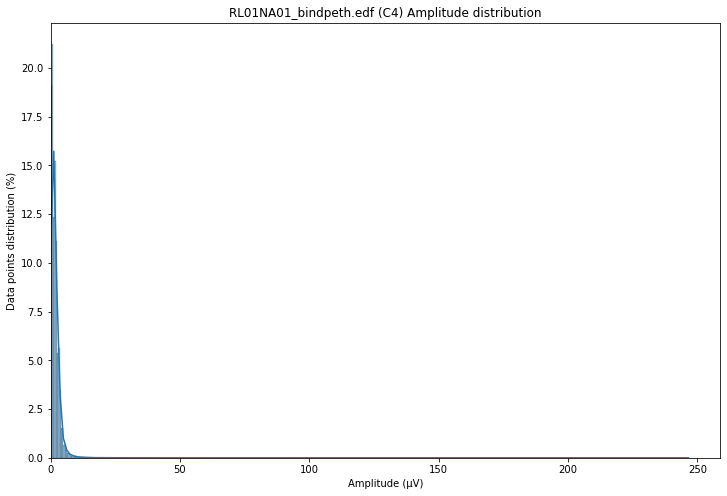

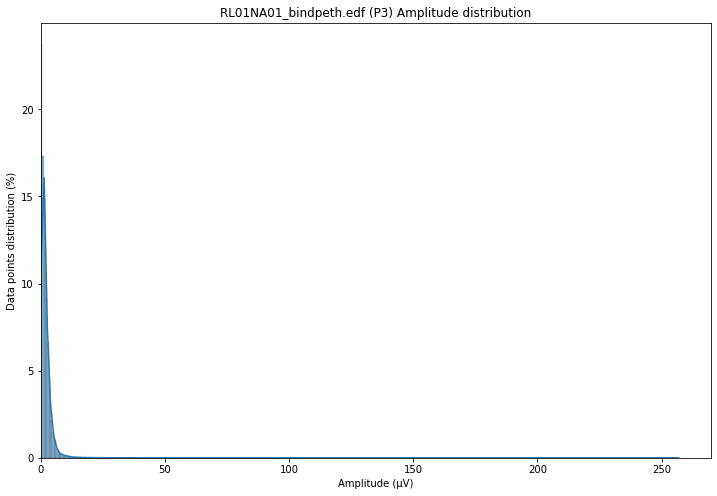

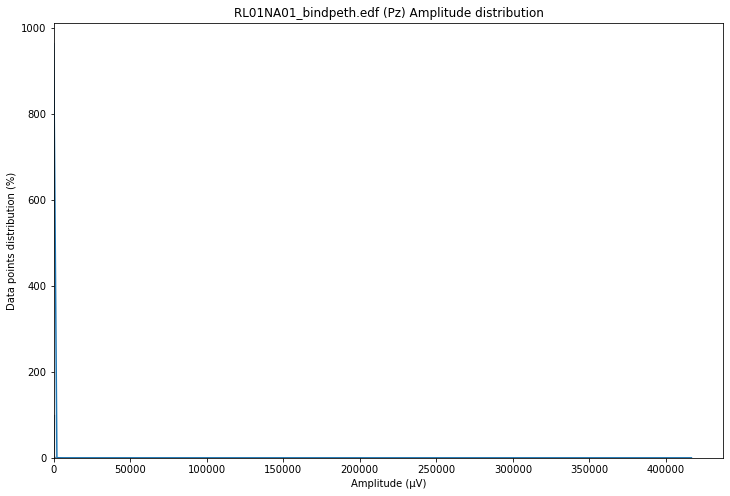

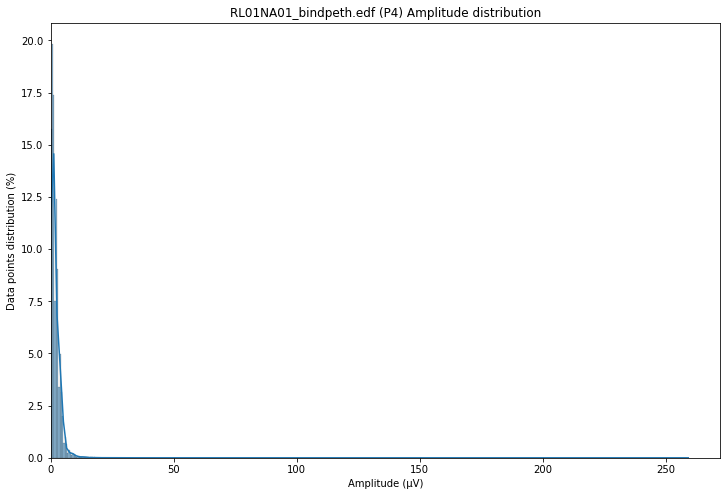

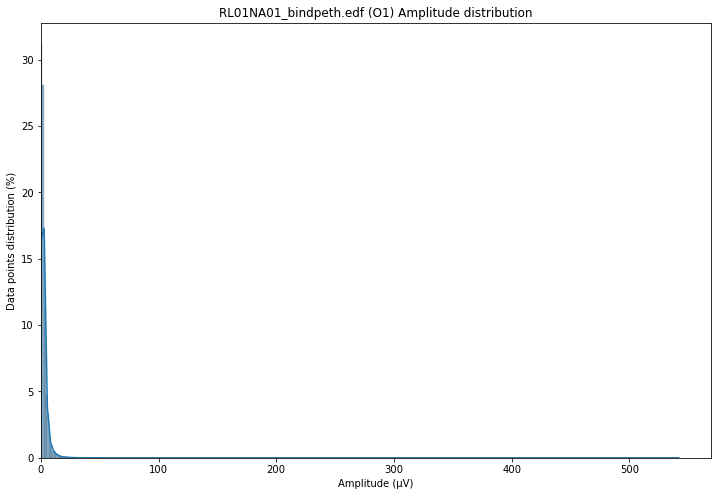

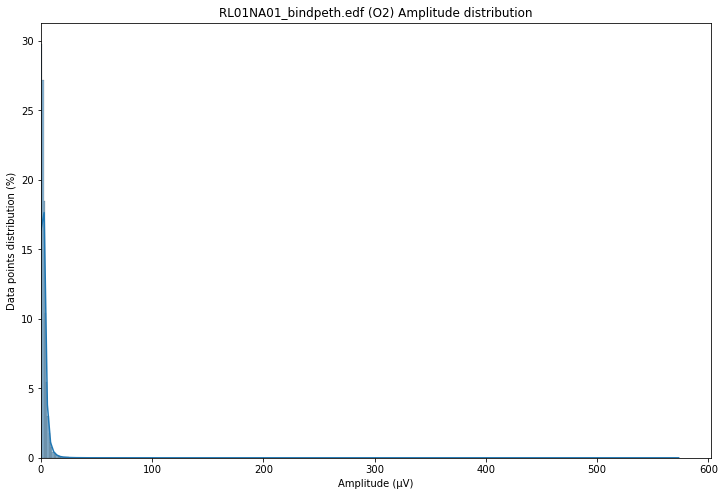

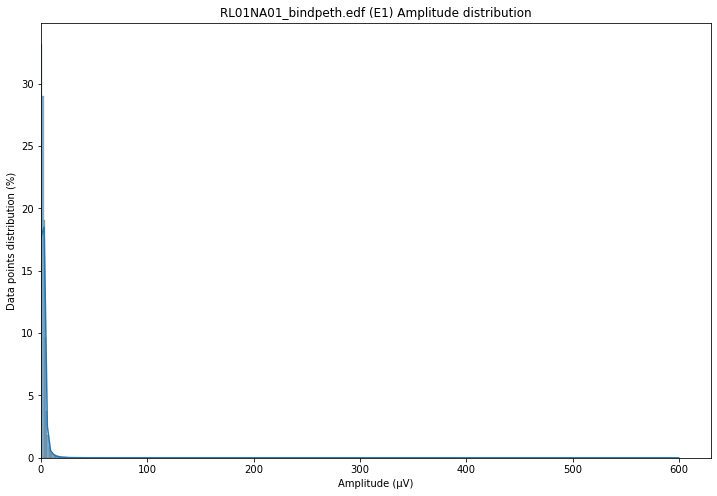

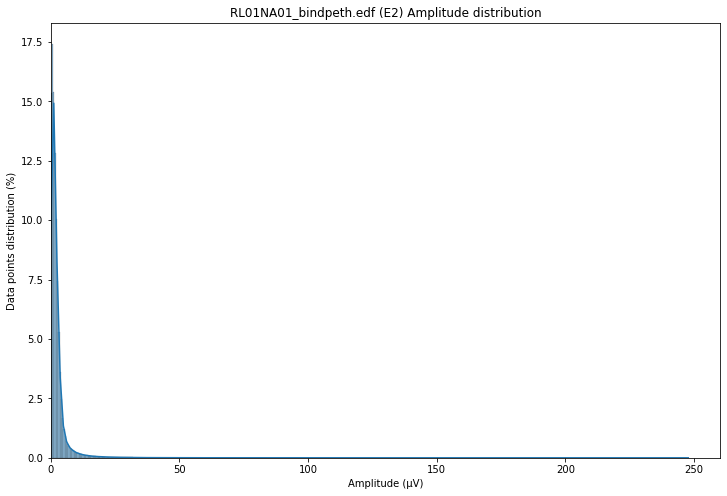

In [10]:
uVchan = summary_table['Unit'] == 'µV'
outOfuVRange = (summary_table['BinGap'] > 0.1)
bit_depth_uVchan = uVchan & outOfuVRange

mVchan = summary_table['Unit'] == 'mV'
outOfmVRange = summary_table['BinGap'] > 0.001
bit_depth_mVchan = mVchan & outOfmVRange

bit_depth_files = summary_table[bit_depth_uVchan | bit_depth_mVchan]
show_channels_histograms(
    bit_depth_files,
    subfolder,
    lambda x: np.abs(np.diff(x))
)